# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
  
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы; 
- Контролировать добросовестность кассиров при продаже алкоголя. 
  
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста. 

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')

from PIL import Image
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

### Размер выборки

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Посмотрим общую информацию и посмотрим на размер выборки:

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Выборка содержит 7591 запись.

### Распределения возраста в выборке

Пострим график распределения возраста в выборке:

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


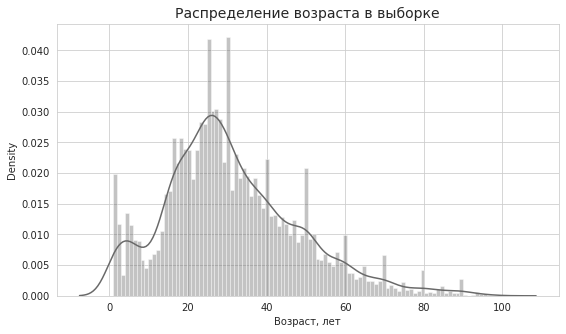

In [5]:
plt.figure(figsize=(9,5))
sns.distplot(labels['real_age'], color='dimgrey', bins=100)
plt.title('Распределение возраста в выборке', size=14)
plt.xlabel('Возраст, лет');

### Визуальная оценка фотографий

Image size - (114, 114, 3)


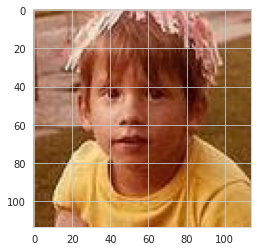

Image size - (784, 784, 3)


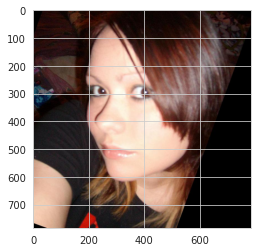

Image size - (133, 133, 3)


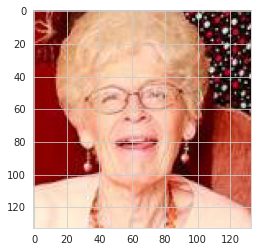

Image size - (370, 370, 3)


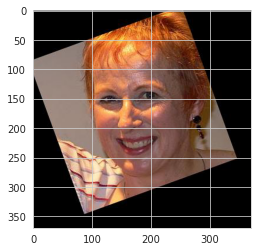

Image size - (212, 212, 3)


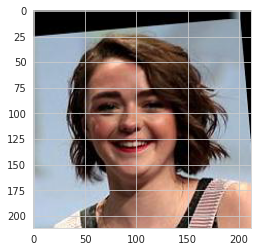

Image size - (636, 637, 3)


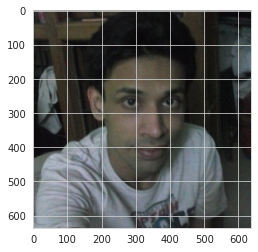

Image size - (412, 412, 3)


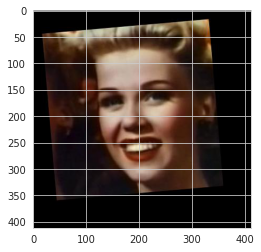

Image size - (311, 311, 3)


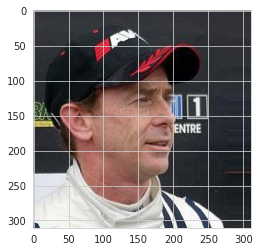

Image size - (898, 897, 3)


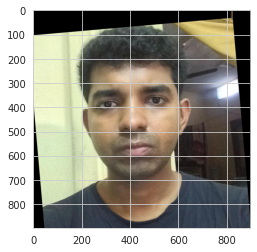

Image size - (724, 724, 3)


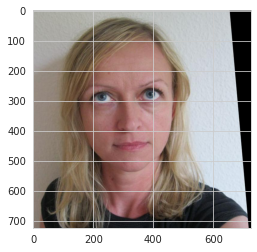

Image size - (636, 636, 3)


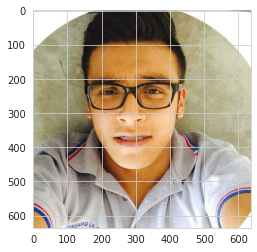

Image size - (803, 803, 3)


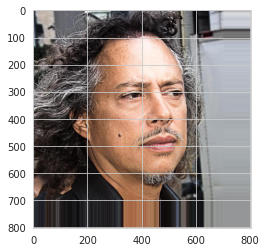

Image size - (155, 155, 3)


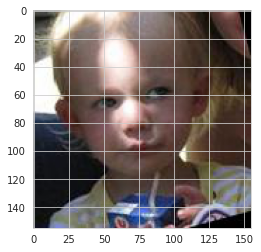

Image size - (321, 321, 3)


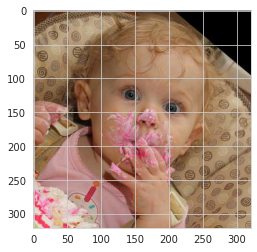

Image size - (203, 204, 3)


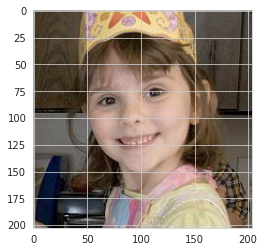

In [6]:
for i in range(15):
    if i < 10:
        number = '0' + str(i)
    else:
        number = i
        
    image = np.array(Image.open(f'/datasets/faces/final_files/0000{number}.jpg'))
    
    print('Image size -', image.shape)
    
    plt.imshow(image)
    plt.show()

### Выводы

В результате исследовательского анализа можно сделать следующие выводы:  
- выборка состоит из 7591 цветных фотографий разного размера;
- основная часть людей на изображениях в возрасте 20-30 лет c пиками 25 и 30 лет;
- годовалых младенцев больше, чем 10-12 летних детей;
- встречаются скачки в возрасте 40, 50, 60, 70, 80, 90 лет;
- судя по образцам, представленным на фото, фотографии повернуты и сдвинуты таким образом, чтобы лица имели вертикальное положение и находились в середине изображения.

## Обучение модели

### Загрузка обучающей выборки

```python
def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=42)
    
    return train_gen_flow
```

### Загрузка тестовой подвыборки

```python
def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.20, rescale=1./255)

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=42)
    
    return test_gen_flow
```

### Создание модели

Я использовала архитектуру ResNet.  
Основные слои предобучены на ImageNet.    
Финальный слой представлен одним нейроном и активацией ReLU.  

```python
def create_model(input_shape):

    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])

    return model
```

### Запуск модели

```python
def train_model(model, train_data, test_data, batch_size=None, 
                epochs=5, steps_per_epoch=None, validation_steps=None):


    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,        
              verbose=2, 
              shuffle=True)

    return model
```

### Процесс обучения

```

Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1518 validated image filenames.
Train for 356 steps, validate for 95 steps
Epoch 1/5
356/356 - 60s - loss: 10.4082 - mae: 10.4020 - val_loss: 20.3449 - val_mae: 20.3411
Epoch 2/5
356/356 - 40s - loss: 7.1459 - mae: 7.1451 - val_loss: 12.0236 - val_mae: 12.0259
Epoch 3/5
356/356 - 37s - loss: 6.0783 - mae: 6.0782 - val_loss: 7.3718 - val_mae: 7.3727
Epoch 4/5
356/356 - 38s - loss: 5.2200 - mae: 5.2203 - val_loss: 6.9031 - val_mae: 6.9017
Epoch 5/5
356/356 - 54s - loss: 4.7060 - mae: 4.7057 - val_loss: 6.9993 - val_mae: 6.9995

95/95 - 9s - loss: 6.9993 - mae: 6.9995
Test MAE: 6.9995

```

### Выводы

На данном этапе была создана нейронная сеть с архитектурой ResNet.  
Сверточные слои были предобучены на ImageNet.  
Обучение модели проходило в течение 5 эпох с learning rate = 0.0001 и алгоритмом Аdam. 

В результате МАЕ на валидационной 6.99. Результат лучше 7.

## Анализ обученной модели

На валидационной выборке обученная модель ошибается в среднем на 7 лет. Я уверена, что при настройке параметров, можно добиться лучших показателей. Обучение 1 эпохи происходит в течение 60 секунд.

## Общий вывод

Цель исследования выполнена: обученная модель демонстрирует показатель MAE = 6.99 без настройки параметров и аугментации данных.

Исходные данные содержали 7591 записей, без пропусков и выбросов. Большинство людей на фотографиях запечетлено в возрастном диапазоне 20-30 лет. 

Модель лучше подходит для решения бизнес-задачи - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, т.к ошибка 6.99 лет не позволяет контролировать добросовестность кассиров при продаже алкоголя.